## Generated figures:
* 2E (place cell reliability)
* S1J (place cell jitter)
* S1K (place cell width)

Also includes statisitcal tests for all three of these plots.  
Finally, we generate a figure that was used in the review response.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import sem, ranksums
from scipy.ndimage import gaussian_filter1d

from os import sys
sys.path.append('..')
import data_util
import plotting_util
import style

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = "none"

FIG_DIR = "../figures/"

In [5]:
data = data_util.load_all_binned_pc_activity()
data_z = data_util.load_all_binned_pc_activity(z_score=True)

day  0
day  1
day  2
day  3
day  4
day  5
day  6
day  0
day  1
day  2
day  3
day  4
day  5
day  6


In [6]:
num_bins = 10

bin_centers = (np.arange(num_bins) + .5) * (4. / num_bins)
binned_width_mean_and_sem = np.zeros((6, 2, num_bins))
binned_reliability_mean_and_sem = np.zeros((6, 2, num_bins))
binned_jitter_mean_and_sem = np.zeros((6, 2, num_bins))

#days, PCs, (center, width, jitter, reliability)
pc_info_days = []

for day_num in range(6):
    #Get PCs and compute centers.
    X_pc = np.copy(data[day_num])
    N_pc = len(X_pc)
    X_pc[:, :, 0] = 0.
    X_pc_avg = X_pc.mean(axis=1)
    centers = X_pc_avg[:, 1:].argmax(axis=1) + 1 #Exclude 0th bin
    
    #Zero out non-place activity
    d = 10
    X_pc_smooth = np.copy(X_pc) #gaussian_filter1d(X_pc, axis=2, sigma=1e-12)
    for i in range(N_pc):
        c = centers[i]
        i1 = max(1, c-d)
        i2 = min(40, c+d)
        X_pc_smooth[i, :, :i1] = 0.
        X_pc_smooth[i, :, i2:] = 0.
    X_pc_smooth_avg = X_pc_smooth.mean(axis=1)
    
    #Compute and bin widths
    single_trial_widths = (X_pc_smooth.sum(axis=2)) / (X_pc_smooth.max(axis=2) + 1e-8)
    single_trial_widths[X_pc_smooth.sum(axis=2) < 1e-3] = np.nan
    widths = np.nanmean(single_trial_widths, axis=1)
    #widths = X_pc_smooth_avg.sum(axis=1) / X_pc_smooth_avg.max(axis=1)
    
    #Convert bins to m
    widths *= .1
    #Bin.
    binned_width_mean_and_sem[day_num] \
        = data_util.bin_xy(centers, widths, (0, 40), num_bins)[1:]
    
    #Compute and bin reliability vals (% active trials in +-1 bin)
    X_z_pc = data_z[day_num]
    reliability_vals = np.zeros(N_pc)
    for i in range(N_pc):
        c = centers[i]
        c1, c2 = c-1, c+2
        reliability_vals[i] = (X_z_pc[i, :, c1:c2].max(axis=1) > 1.).mean()
    #Convert fraction of 1 to %.
    reliability_vals *= 100
    #Bin.
    binned_reliability_mean_and_sem[day_num] \
        = data_util.bin_xy(centers, reliability_vals, (0, 40), num_bins)[1:]
    
    #Compute and bin jitter vals.
    single_trial_centers = X_pc_smooth.argmax(axis=2).astype(np.float)
    single_trial_centers[X_pc_smooth.sum(axis=2) < 1e-3] = np.nan
    trial_avg_centers = np.nanmean(single_trial_centers, axis=1)
    single_trial_deviations = single_trial_centers - trial_avg_centers[:, np.newaxis]
    jitter_vals = np.sqrt(np.nanmean(single_trial_deviations**2, axis=1))
    #Convert bins to m.
    jitter_vals *= .1
    #Bin.
    binned_jitter_mean_and_sem[day_num] \
        = data_util.bin_xy(centers, jitter_vals, (0, 40), num_bins)[1:]
    
    #Convert bins to m.
    centers = centers * .1
    pc_info_days.append(np.array([centers, widths, reliability_vals, jitter_vals]).T)
    


In [7]:
def plot_metric(bin_centers, mean_and_sem, ylabel, day1=0, day2=4, c1=style.day_0_color, c2=style.day_4_color):
    fig, ax = plt.subplots(1, 1, figsize=(2., 1.2), dpi=320)
    ax.errorbar(x=bin_centers, y=mean_and_sem[day1, 0], yerr=mean_and_sem[day1, 1], c=c1, **style.errorbar_style)
    ax.errorbar(x=bin_centers, y=mean_and_sem[day2, 0], yerr=mean_and_sem[day2, 1], c=c2, **style.errorbar_style)
    ax.set_xlabel("Distance (m)", **style.label_style)
    ax.set_xticks(range(5))
    ax.set_ylabel(ylabel, **style.label_style)
    plotting_util.prettyify_ax(ax)
    return fig, ax

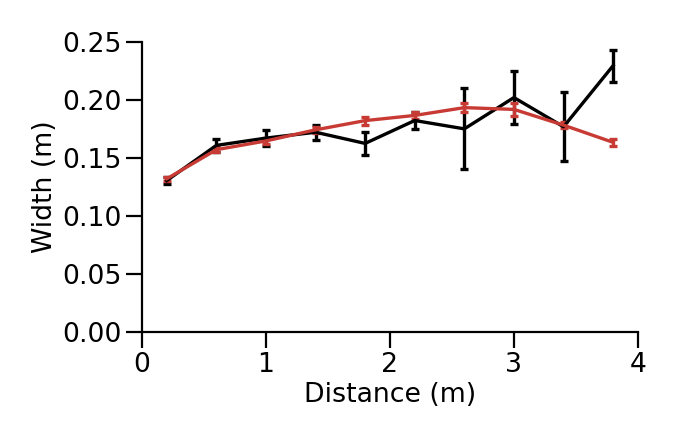

In [9]:
fig, ax = plot_metric(bin_centers, binned_width_mean_and_sem, "Width (m)")
ax.set_ylim(0, .25)

plt.savefig(FIG_DIR + "width_vs_distance.svg", bbox_inches="tight")

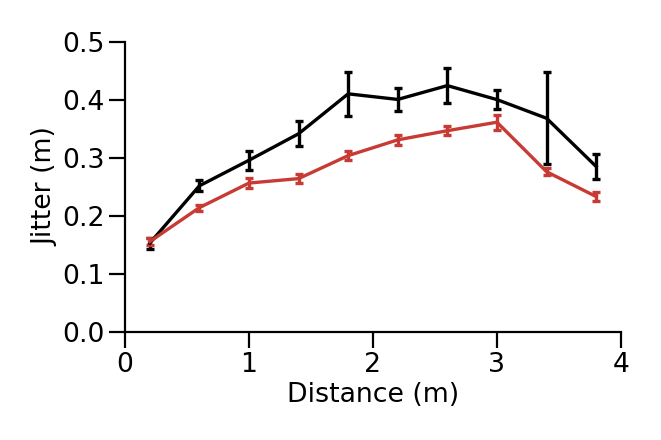

In [10]:
fig, ax = plot_metric(bin_centers, binned_jitter_mean_and_sem, "Jitter (m)")
ax.set_ylim([0, .5])

plt.savefig(FIG_DIR + "jitter_vs_distance.svg", bbox_inches="tight")

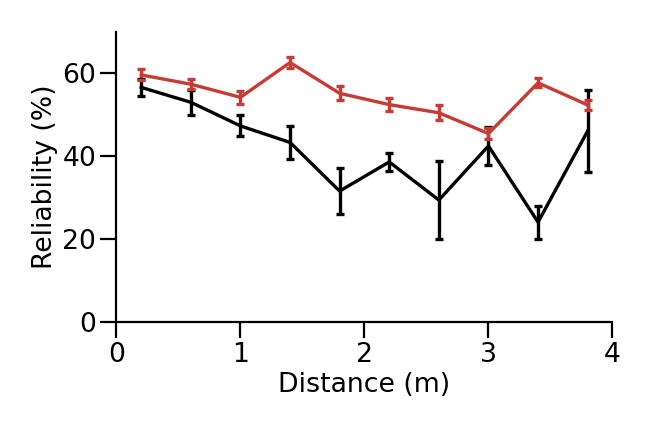

In [11]:
fig, ax = plot_metric(bin_centers, binned_reliability_mean_and_sem, "Reliability (%)")
ax.set_ylim([0, 70])

plt.savefig(FIG_DIR + "reliability_vs_distance.svg", bbox_inches="tight")

In [12]:
"""
Run statistical tests
"""

first_half_widths_days = [pc_info[pc_info[:, 0] < 2., 1] for pc_info in pc_info_days]
second_half_widths_days = [pc_info[pc_info[:, 0] >= 2., 1] for pc_info in pc_info_days]
width_days = [pc_info[:, 1] for pc_info in pc_info_days]

first_half_reliability_days = [pc_info[pc_info[:, 0] < 2., 2] for pc_info in pc_info_days]
second_half_reliability_days = [pc_info[pc_info[:, 0] >= 2., 2] for pc_info in pc_info_days]
reliability_days = [pc_info[:, 2] for pc_info in pc_info_days]

first_half_jitter_days = [pc_info[pc_info[:, 0] < 2., 3] for pc_info in pc_info_days]
second_half_jitter_days = [pc_info[pc_info[:, 0] >= 2, 3] for pc_info in pc_info_days]
jitter_days = [pc_info[:, 3] for pc_info in pc_info_days]

for day_num in range(6):
    print("Day", day_num)
    pc_centers = pc_info_days[day_num][:, 0]
    print("<2", np.sum(pc_centers < 2.), "... >=2", np.sum(pc_centers >= 2.))
    test_result_width = ranksums(first_half_widths_days[day_num], second_half_widths_days[day_num])
    test_result_reliability = ranksums(first_half_reliability_days[day_num], second_half_reliability_days[day_num])
    test_result_jitter = ranksums(first_half_jitter_days[day_num], second_half_jitter_days[day_num])
    
    print("Width (1st vs. 2nd half):", test_result_width)
    print("0.1-2m", np.mean(first_half_widths_days[day_num]), sem(first_half_widths_days[day_num]))
    print("2-4m", np.mean(second_half_widths_days[day_num]), sem(second_half_widths_days[day_num]))
    print("overall", np.mean(width_days[day_num]), sem(width_days[day_num]))
    
    print("Reliability (1st vs. 2nd half):", test_result_reliability)
    print("0.1-2m", np.mean(first_half_reliability_days[day_num]), sem(first_half_reliability_days[day_num]))
    print("2-4m", np.mean(second_half_reliability_days[day_num]), sem(second_half_reliability_days[day_num]))
    print("overall", np.mean(reliability_days[day_num]), sem(reliability_days[day_num]))
    
    print("Jitter (1st vs. 2nd half):", test_result_jitter)
    print("0.1-2m", np.mean(first_half_jitter_days[day_num]), sem(first_half_jitter_days[day_num]))
    print("2-4m", np.mean(second_half_jitter_days[day_num]), sem(second_half_jitter_days[day_num]))
    print("overall", np.mean(jitter_days[day_num]), sem(jitter_days[day_num]))
    
    print("")

print("Relibaility (day 0 vs. 4):", ranksums(reliability_days[0], reliability_days[4]))
print("Relibaility SECOND HALF (day 0 vs. 4):", ranksums(second_half_reliability_days[0], second_half_reliability_days[4]))
print("Relibaility FIRST HALF (day 0 vs. 4):", ranksums(first_half_reliability_days[0], first_half_reliability_days[4]))

print("Jitter (0/4):", ranksums(jitter_days[0], jitter_days[4]))
print("Jitter SECOND HALF (day 0 vs. 4):", ranksums(second_half_jitter_days[0], second_half_jitter_days[4]))
print("Jitter FIRST HALF (day 0 vs. 4):", ranksums(first_half_jitter_days[0], first_half_jitter_days[4]))

print("Width (day 0 vs. 4):", ranksums(width_days[0], width_days[4]))
print("Width SECOND HALF (day 0 vs. 4):", ranksums(second_half_widths_days[0], second_half_widths_days[4]))
print("Width FIRST HALF (day 0 vs. 4):", ranksums(first_half_widths_days[0], first_half_widths_days[4]))



Day 0
<2 146 ... >=2 23
Width (1st vs. 2nd half): RanksumsResult(statistic=-4.548178371267378, pvalue=5.41122634455396e-06)
0.1-2m 0.1488648158045186 0.0026452813294099366
2-4m 0.1889948660994712 0.007876359452210206
overall 0.15432630193933464 0.0027295105976213154
Reliability (1st vs. 2nd half): RanksumsResult(statistic=3.8214785004549996, pvalue=0.00013265398042827868)
0.1-2m 51.534246575342465 1.451862270104182
2-4m 37.56521739130435 2.2596530628074363
overall 49.633136094674555 1.341373700767065
Jitter (1st vs. 2nd half): RanksumsResult(statistic=-6.015332684579436, pvalue=1.7951763569845988e-09)
0.1-2m 0.23074845343091469 0.00917818576954022
2-4m 0.39049129561848067 0.014025597254990911
overall 0.25248860355111596 0.0091747274028453

Day 1
<2 204 ... >=2 62
Width (1st vs. 2nd half): RanksumsResult(statistic=-4.386523366795139, pvalue=1.1517679685367742e-05)
0.1-2m 0.14715634211708245 0.0020714933354726924
2-4m 0.16637021232028637 0.004270087343463167
overall 0.15163476299151346 0

In [13]:
"""
For Neuron Review
"""

num_bins = 10
bin_centers = (np.arange(num_bins) + .5) * (4. / num_bins)
def load_stuff(mouse_num, mode):
    if mode == 0:
        data = data_util.load_preprocessed_data(mouse_num=mouse_num, day_num=5, load_day_5_pinene=True)
        X = data['neural'][1]
        X_z = data['z_score'][1]
    if mode == 1:
        data = data_util.load_preprocessed_data(mouse_num=mouse_num, day_num=5, load_day_5_pinene=False)
        X = data['neural'][0]
        X_z = data['z_score'][0]
    elif mode == 2:
        data = data_util.load_preprocessed_data(mouse_num=mouse_num, day_num=4)
        X = data['neural'][1]
        X_z = data['z_score'][1]
    pc_idx = data_util.get_pc_idx(X, X_z)
    X_pc = X[:, :, pc_idx].transpose(2, 0, 1)
    X_z_pc = X_z[:, :, pc_idx].transpose(2, 0, 1)
    N_pc = len(X_pc)
    X_pc[:, :, 0] = 0.
    X_pc_avg = X_pc.mean(axis=1)
    centers = X_pc_avg[:, 1:].argmax(axis=1) + 1 #Exclude 0th bin
    #Compute and bin reliability vals (% active trials in +-1 bin)
    reliability_vals = np.zeros(N_pc)
    for i in range(N_pc):
        c = centers[i]
        c1, c2 = c-1, c+2
        reliability_vals[i] = (X_z_pc[i, :, c1:c2].max(axis=1) > 1.).mean()
    #Convert fraction of 1 to %.
    reliability_vals *= 100
    return centers, reliability_vals

def load_all(mode):
    all_centers = np.array([])
    all_rel = np.array([])
    for mouse_num in range(1, 6):
        c, rel = load_stuff(mouse_num, mode)
        all_centers = np.concatenate((all_centers, c))
        all_rel = np.concatenate((all_rel, rel))
    binned = data_util.bin_xy(all_centers, all_rel, (0, 40), num_bins)[1:]
    return binned


binned_1 = load_all(0)
binned_2 = load_all(1)
binned_3 = load_all(2)

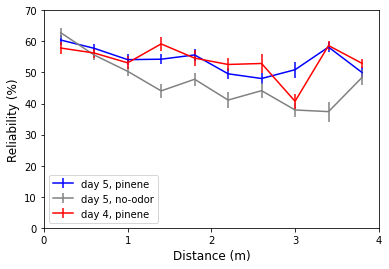

In [14]:
plt.errorbar(x=bin_centers, y=binned_1[0], yerr=binned_1[1], label="day 5, pinene", color="blue")
plt.errorbar(x=bin_centers, y=binned_2[0], yerr=binned_2[1], label="day 5, no-odor", color="gray")
plt.errorbar(x=bin_centers, y=binned_3[0], yerr=binned_3[1], label="day 4, pinene", color="red")

plt.ylabel("Reliability (%)", fontsize=12)
plt.xlabel("Distance (m)", fontsize=12)
plt.ylim(0, 70)
plt.xticks([0, 1, 2, 3, 4])
plt.legend()

plt.savefig(FIG_DIR + "day_4_vs_5_reliability.svg", bbox_inches="tight")